In [1]:
# Executing this cell does some magic
%load_ext autoreload
%autoreload 2

In [2]:
import sys
# Add the `src` folder to the system path
src_path = '../src'  # Replace with the actual path to the `src` folder
sys.path.append(src_path)

In [3]:
# Required imports
import pandas as pd
import torch
from torch.utils.data import DataLoader
import os
import numpy as np

# Assuming these scripts are in src/ or current directory
from dataset.rating_dataset import preprocess_data, RatingDataset  # Adjust path as needed
from dataset.anime_data import AnimeData  # Adjust path as needed
from eval.evaluate import evaluate_mse   # Adjust path as needed
from models.genre_baseline import GenreBaselineModel  # Adjust path as needed


## Step 1: Preprocess Data

We'll get `train_dataset`, `val_dataset`, and `test_dataset` using our `preprocess_data` function.


In [4]:
train_dataset, val_dataset, test_dataset = preprocess_data(
    filepath='../data/raw/animelist.csv',
    user_range=10000,  # For example, limit to first 10k users
    include_watching_status=False,
    include_watched_episodes=False,
    zero_strategy='average',
    random_state=42,
    save_interaction_matrix=True
)

len_train = len(train_dataset)
len_val = len(val_dataset)
len_test = len(test_dataset)

print(f"Training samples: {len_train}, Validation samples: {len_val}, Test samples: {len_test}")


Training samples: 2600126, Validation samples: 325016, Test samples: 325016


In [5]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


## Step 2: Initialize AnimeData

We'll load the anime metadata, which will allow us to query genres and compute global genre means.


In [6]:
anime_data = AnimeData(filepath='../data/raw/anime.csv')
print("Anime DataFrame shape:", anime_data.df.shape)
print("Columns:", anime_data.list_columns())


Anime DataFrame shape: (17562, 37)
Columns: ['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name', 'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors', 'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity', 'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped', 'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6', 'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'StartDate', 'EndDate']


## Step 3: Initialize and Fit Collaborative Filtering Model

We'll create an instance of `MatrixFactorizationModel` and then fit it on the training data. The `fit` method expects a DataFrame with `user_id, anime_id, rating`. We can get that from `train_dataset`.


In [7]:
from models.matrix_factorization import MatrixFactorizationModel
import torch.nn as nn
import matplotlib.pyplot as plt

# Ensure proper remapping of IDs
user_mapping = {uid: idx for idx, uid in enumerate(train_dataset.data['user_id'].unique())}
anime_mapping = {aid: idx for idx, aid in enumerate(train_dataset.data['anime_id'].unique())}

# Apply remapping and handle unmapped IDs
for dataset in [train_dataset, val_dataset, test_dataset]:
    dataset.data['user_id'] = dataset.data['user_id'].map(user_mapping).fillna(0).astype(int)
    dataset.data['anime_id'] = dataset.data['anime_id'].map(anime_mapping).fillna(0).astype(int)

# Verify ranges
print(f"Max user_id: {train_dataset.data['user_id'].max()}, Max anime_id: {train_dataset.data['anime_id'].max()}")
print(f"Min user_id: {train_dataset.data['user_id'].min()}, Min anime_id: {train_dataset.data['anime_id'].min()}")

# Ensure number of users and items match remapped IDs
num_users = len(user_mapping)
num_items = len(anime_mapping)

embedding_dims = [4, 8, 16, 32]  # Different embedding dimensions to try
all_losses = {}  # Store losses for visualization

best_embedding_dim = None
best_val_loss = float('inf')

for dim in embedding_dims:
    print(f"Training with embedding_dim={dim}")
    model = MatrixFactorizationModel(num_users=num_users, num_items=num_items, embedding_dim=dim)
    train_loss_history, val_loss_history = model.fit(
        train_loader, val_loader=val_loader, num_epochs=8, lr=0.001, device='cpu'
    )
    final_val_loss = model.evaluate(val_loader, nn.MSELoss(), device='cpu')
    
    print(f"Validation Loss for embedding_dim={dim}: {final_val_loss:.4f}")

    all_losses[dim] = {
        'train_loss_history': train_loss_history,
        'val_loss_history': val_loss_history
    }

    if final_val_loss < best_val_loss:
        best_model = model
        best_val_loss = final_val_loss
        best_embedding_dim = dim

print(f"Best embedding_dim: {best_embedding_dim}, with Validation Loss: {best_val_loss:.4f}")


Max user_id: 9978, Max anime_id: 15925
Min user_id: 0, Min anime_id: 0
Training with embedding_dim=4
Epoch 1/8, Training Loss: 12.6612
Epoch 1/8, Validation Loss: 1.6702
Epoch 2/8, Training Loss: 1.4095
Epoch 2/8, Validation Loss: 1.2882
Epoch 3/8, Training Loss: 1.2323
Epoch 3/8, Validation Loss: 1.1979
Epoch 4/8, Training Loss: 1.1539
Epoch 4/8, Validation Loss: 1.1349
Epoch 5/8, Training Loss: 1.1041
Epoch 5/8, Validation Loss: 1.1022
Epoch 6/8, Training Loss: 1.0738
Epoch 6/8, Validation Loss: 1.0825
Epoch 7/8, Training Loss: 1.0508
Epoch 7/8, Validation Loss: 1.0689
Epoch 8/8, Training Loss: 1.0340
Epoch 8/8, Validation Loss: 1.0606
Validation Loss for embedding_dim=4: 1.0606
Training with embedding_dim=8
Epoch 1/8, Training Loss: 11.4356
Epoch 1/8, Validation Loss: 1.5165
Epoch 2/8, Training Loss: 1.3278
Epoch 2/8, Validation Loss: 1.2232
Epoch 3/8, Training Loss: 1.1597
Epoch 3/8, Validation Loss: 1.1362
Epoch 4/8, Training Loss: 1.0928
Epoch 4/8, Validation Loss: 1.0971
Epoch 5

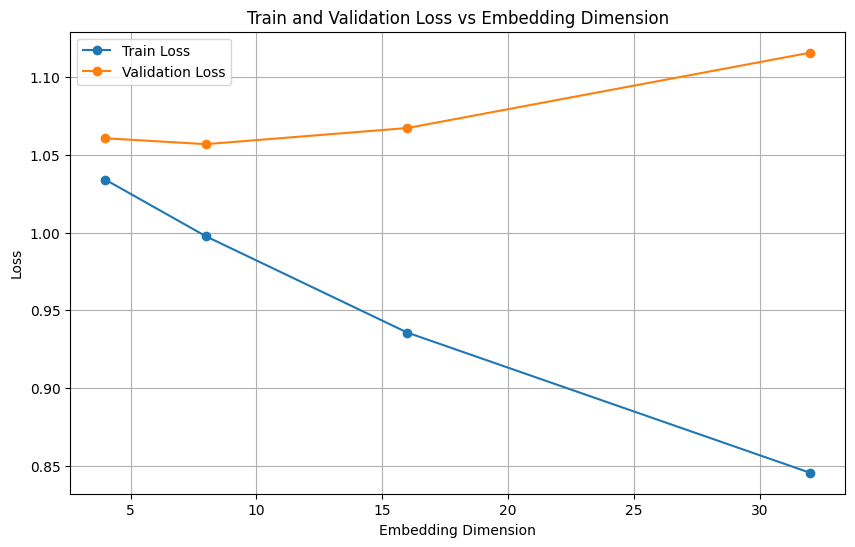

In [10]:
# Visualization block
plt.figure(figsize=(12, 8))

for dim, losses in all_losses.items():
    plt.plot(losses['train_loss_history'], label=f'Train Loss (dim={dim})', marker='o')
    plt.plot(losses['val_loss_history'], label=f'Validation Loss (dim={dim})', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History for Different Embedding Dimensions')
plt.legend()
plt.grid()
plt.show()

## Step 4: Test Predictions

Let's pick a few random user-item pairs from the validation set and see what the model predicts.


In [11]:
val_df = val_dataset.data
sample = val_df.sample(5, random_state=42)

user_ids = torch.tensor(sample['user_id'].values, dtype=torch.long)
item_ids = torch.tensor(sample['anime_id'].values, dtype=torch.long)
actual_ratings = sample['rating'].values

predictions = best_model(user_ids, item_ids)

for u, i, actual, pred in zip(user_ids, item_ids, actual_ratings, predictions):
    print(f"User {u.item()}, Item {i.item()} | Actual: {actual}, Predicted: {pred.item()}")


User 4280, Item 606 | Actual: 7.0, Predicted: 7.42995023727417
User 368, Item 1805 | Actual: 6.0, Predicted: 6.910248279571533
User 1261, Item 462 | Actual: 7.3391442155309035, Predicted: 8.167037963867188
User 2116, Item 1485 | Actual: 9.0, Predicted: 9.462530136108398
User 1513, Item 4003 | Actual: 5.0, Predicted: 6.639827728271484


We see how the collaborative filtering model predicts ratings.

## Step 5: Evaluate Model

Now we use the `evaluate_mse` function to compute MSE on the validation and test sets.


In [13]:
val_mse = evaluate_mse(best_model, val_loader, device='cpu')
test_mse = evaluate_mse(best_model, test_loader, device='cpu')

print("Validation MSE:", val_mse)
print("Test MSE:", test_mse)


Validation MSE: 1.0569001613901634
Test MSE: 1.058590491660678
